# Make a decent bar chart for feature importance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rfpimp import *


features = ['bedrooms','bathrooms','doorman','parking','laundry','walkup','ac','nofee','coop']
values = np.array([0.697091628, 0.181579262, 0.09046983, 0.0149105083, 0.00709949088, 0.00519591132, 0.00361618919, 3.71797701e-05, 0.0])

I = pd.DataFrame()
I['Feature'] = features
I['Importance'] = values
I = I.set_index('Feature')
I

,Importance
Feature,
bedrooms,0.697092
bathrooms,0.181579
doorman,0.090470
parking,0.014911
laundry,0.007099
walkup,0.005196
ac,0.003616
nofee,0.000037
coop,0.000000


In [2]:
features2 = ['bedrooms','bathrooms','doorman']
values2 = np.array([0.697091628, 0.181579262, 0.09046983])

I2 = pd.DataFrame()
I2['Feature'] = features2
I2['Importance'] = values2
I2 = I2.set_index('Feature')
I2

,Importance
Feature,
bedrooms,0.697092
bathrooms,0.181579
doorman,0.090470


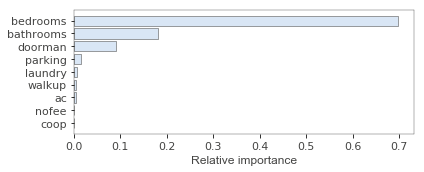

In [3]:
plot_importances(I, width=6)

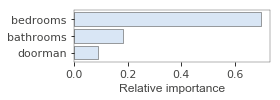

In [5]:
plot_importances(I2, width=4)

# Breast cancer importances

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

cancer = load_breast_cancer()

X, y = cancer.data, cancer.target
df = pd.DataFrame(X, columns=cancer.feature_names)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2) 

cl = RandomForestClassifier(n_estimators=100)
cl.fit(X_train, y_train)
cl.score(X_test, y_test)

0.8771929824561403

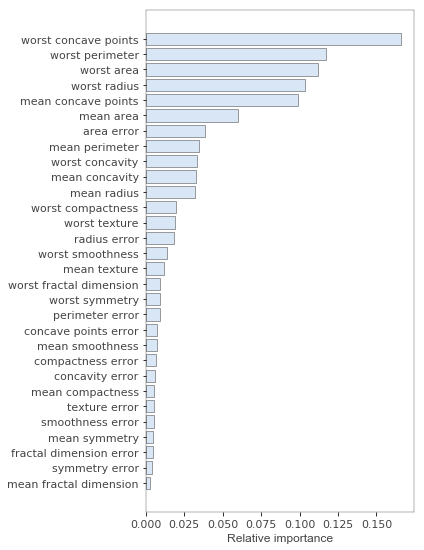

In [19]:
I = pd.DataFrame()

I['Feature'] = X_train.columns
I['Importance'] = cl.feature_importances_
I = I.sort_values('Importance', ascending=False)
I = I.set_index('Feature')
plot_importances(I, width=6)

baseline 1.0
mean radius missing score 1.0
mean texture missing score 1.0
mean perimeter missing score 1.0
mean area missing score 1.0
mean smoothness missing score 1.0
mean compactness missing score 1.0
mean concavity missing score 1.0
mean concave points missing score 0.9655172413793104
mean symmetry missing score 1.0
mean fractal dimension missing score 1.0
radius error missing score 1.0
texture error missing score 1.0
perimeter error missing score 1.0
area error missing score 1.0
smoothness error missing score 1.0
compactness error missing score 1.0
concavity error missing score 1.0
concave points error missing score 1.0
symmetry error missing score 1.0
fractal dimension error missing score 1.0
worst radius missing score 1.0
worst texture missing score 1.0
worst perimeter missing score 1.0
worst area missing score 1.0
worst smoothness missing score 1.0
worst compactness missing score 1.0
worst concavity missing score 1.0
worst concave points missing score 0.9655172413793104
worst s

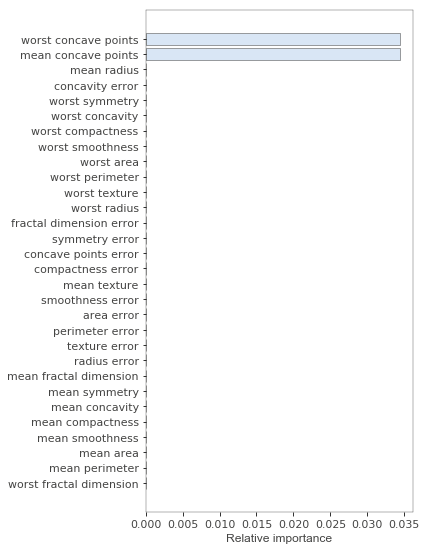

In [44]:
def dropcol_importances(model, X_train, y_train, X_valid = None, y_valid = None, metric=None, sample_weights = None):
    """
    Compute drop-column feature importances for scikit-learn.

    Given a classifier or regression in model
    and training X and y data, return a data frame with columns
    Feature and Importance sorted in reverse order by importance.

    A clone of model is trained once to get the baseline score and then
    again, once per feature to compute the drop in either the model's .score() output
    or a custom metric callable in the form of metric(model, X_valid, y_valid).
    In case of a custom metric the X_valid and y_valid parameters should be set.

    return: A data frame with Feature, Importance columns

    SAMPLE CODE

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    X_train, y_train = ..., ...
    rf.fit(X_train, y_train)
    imp = dropcol_importances(rf, X_train, y_train)
    """
    model_ = clone(model)
    model_.random_state = 999
    model_.fit(X_train, y_train)
    if callable(metric):
        baseline = metric(model_, X_valid, y_valid, sample_weights)
    else:
        baseline = model_.score(X_valid, y_valid, sample_weights)
    print(f"baseline {baseline}")
    imp = []
    for col in X_train.columns:
        model_ = clone(model)
        model_.random_state = 999
        model_.fit(X_train.drop(col,axis=1), y_train)
        if callable(metric):
            s = metric(model_, X_valid.drop(col,axis=1), y_valid, sample_weights)
        else:
            s = model_.score(X_valid.drop(col,axis=1), y_valid, sample_weights)
        drop_in_score = baseline - s
        print(f"{col} missing score {s}")
#        print(f"{col} drop_in_score {drop_in_score}")
        imp.append(drop_in_score)
    imp = np.array(imp)
    I = pd.DataFrame(data={'Feature':X_train.columns, 'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I

I = dropcol_importances(cl, X_train, y_train, X_test, y_test)
plot_importances(I, width=6)

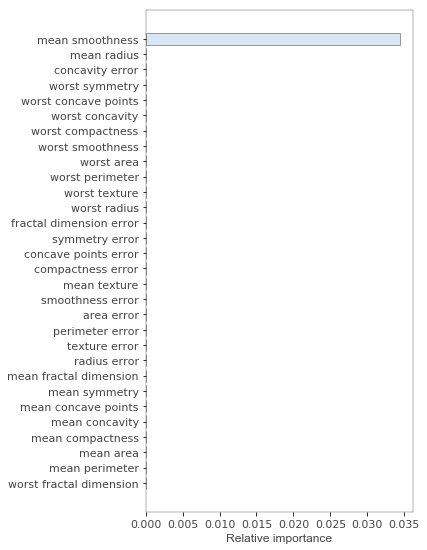

In [43]:
I = importances(cl, X_test, y_test)
plot_importances(I, width=6)

1.0


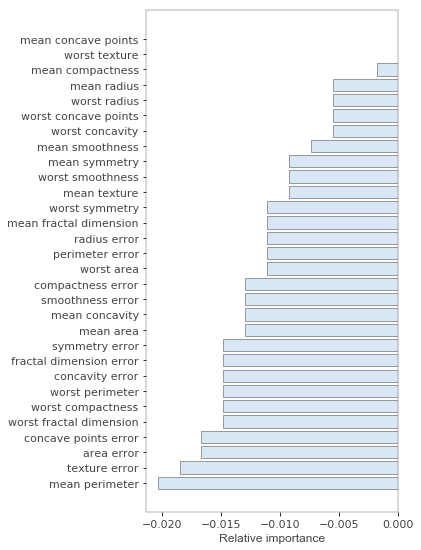

In [40]:
def oob_dropcol_importances(rf, X_train, y_train):
    """
    Compute drop-column feature importances for scikit-learn.

    Given a RandomForestClassifier or RandomForestRegressor in rf
    and training X and y data, return a data frame with columns
    Feature and Importance sorted in reverse order by importance.

    A clone of rf is trained once to get the baseline score and then
    again, once per feature to compute the drop in out of bag (OOB)
    score.

    return: A data frame with Feature, Importance columns

    SAMPLE CODE

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    X_train, y_train = ..., ...
    rf.fit(X_train, y_train)
    imp = oob_dropcol_importances(rf, X_train, y_train)
    """
    rf_ = clone(rf)
    rf_.random_state = 999
    rf_.oob_score = True
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.oob_score = True
        rf_.fit(X_train.drop(col, axis=1), y_train)
        drop_in_score = baseline - rf_.oob_score_
        imp.append(drop_in_score)
    imp = np.array(imp)
    I = pd.DataFrame(data={'Feature':X_train.columns, 'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I

cancer = load_breast_cancer()

X, y = cancer.data, cancer.target
df = pd.DataFrame(X, columns=cancer.feature_names)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.05) 

cl = RandomForestClassifier(n_estimators=100)
cl.fit(X_train, y_train)
print( cl.score(X_test, y_test) )
I = oob_dropcol_importances(cl, X_train, y_train)
plot_importances(I, width=6)